# Prediction Model using TuriCreate in Julia

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Set-Up" data-toc-modified-id="Set-Up-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Set Up</a></span></li><li><span><a href="#Fetch-Data-(SFrame)-from-Uber-CSV" data-toc-modified-id="Fetch-Data-(SFrame)-from-Uber-CSV-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Fetch Data (SFrame) from Uber CSV</a></span></li><li><span><a href="#Split-Data" data-toc-modified-id="Split-Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Split Data</a></span></li><li><span><a href="#Evaluate-the-Model" data-toc-modified-id="Evaluate-the-Model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Evaluate the Model</a></span></li><li><span><a href="#Save-/-Export-the-Model" data-toc-modified-id="Save-/-Export-the-Model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Save / Export the Model</a></span></li><li><span><a href="#Make-predictions" data-toc-modified-id="Make-predictions-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Make predictions</a></span><ul class="toc-item"><li><span><a href="#Explore-SFrame" data-toc-modified-id="Explore-SFrame-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Explore SFrame</a></span></li></ul></li></ul></div>

## Set Up

In [1]:
## normally we receive symbol_to_predict from the calling code in Main.jl

## comment out when exporting .jl file
symbol_to_predict = "DJIA"

println("symbol_to_predict ", symbol_to_predict )

symbol_to_predict DJIA


In [2]:
## Read feature names (columns) form the text file 
features_to_analyze = readlines("../DATA/features_to_analyze.txt") # returns Array{String,1}
 
println()

In [3]:
## uncomment for the first run
# import Pkg
# Pkg.add("PyCall")
# Pkg.add("Conda")
# ENV["PYTHON"] = "/opt/anaconda3/envs/turi/bin/python"
# /opt/anaconda3/envs/turi/lib/python3.6/site-packages/
# Pkg.build("PyCall")

include("../Julia/functions.jl") 
data_path="../DATA/processed/uber_training.csv"
column_to_predict = symbol_to_predict * "_Original"

"DJIA_Original"

## Fetch Data (SFrame) from Uber CSV

In [4]:
using PyCall
tc = pyimport("turicreate")
data = tc.SFrame(data_path)
println()

Finished parsing file /Users/uki/REPOS/MarketIndicators.jl/src/DATA/processed/uber_training.csv
Parsing completed. Parsed 100 lines in 0.044436 secs.
------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,floa

## Split Data

In [5]:
# Make a train-test split
train_data, test_data = data.random_split(0.8)

println( size(train_data) )
println( size(test_data)  )

(1232,)
(286,)


In [6]:
model = tc.regression.create( 
    train_data, 
    target = column_to_predict, 
    features = features_to_analyze, 
    validation_set="auto", 
    verbose=true
)

Automatically generating validation set from 5% of the data.
Linear regression:
--------------------------------------------------------
Number of examples          : 1165
Number of features          : 203
Number of unpacked features : 203
Number of coefficients    : 204
Starting Newton Method
--------------------------------------------------------
+-----------+----------+--------------+--------------------+----------------------+---------------------------------+-----------------------------------+
| Iteration | Passes   | Elapsed Time | Training Max Error | Validation Max Error | Training Root-Mean-Square Error | Validation Root-Mean-Square Error |
+-----------+----------+--------------+--------------------+----------------------+---------------------------------+-----------------------------------+
| 1         | 2        | 1.038219     | 1263.687445        | 1039.066185          | 168.861783                      | 216.467874                        |
+-----------+----------+--------

PyObject Class                          : LinearRegression

Schema
------
Number of coefficients         : 204
Number of examples             : 1165
Number of feature columns      : 203
Number of unpacked features    : 203

Hyperparameters
---------------
L1 penalty                     : 0
L2 penalty                     : 0.01

Training Summary
----------------
Solver                         : newton
Solver iterations              : 1
Solver status                  : SUCCESS: Optimal solution found.
Training time (sec)            : 1.0541

Settings
--------
Residual sum of squares        : 33219161.7115
Training RMSE                  : 168.8618

Highest Positive Coefficients
-----------------------------
(intercept)                    : 36290.9152
DJIA_Avg005                    : 66.8712
US_GDP_Q_Avg060                : 65.146
US_PEND_HOME_SALE_M_Avg120     : 52.7764
US_GDP_Q_Avg180                : 48.5935

Lowest Negative Coefficients
----------------------------
US_GDP_Q_Avg120     

## Evaluate the Model

In [7]:
#TODO: write this in a loop to select the best model
# Evaluate the model and save the results into a dictionary
results = model.evaluate( test_data ) #test_data[0:2531]
results

Dict{Any,Any} with 2 entries:
  "rmse"      => 189.649
  "max_error" => 1200.16

In [8]:
rmse = results["rmse"]
rmse = round(rmse, digits=2)

max_error = results["max_error"]
max_error = round(max_error, digits=2)

println( "max_error: ", max_error, ", rmse: ", rmse )
# max_error: 1069.27, rmse: 184.6
# max_error: 65.35, rmse: 32.6            predict: ^DJIA added: US_INIT_JOBLESS
# max_error: 1875.39, rmse: 443.59        predict: ^DJIA commented out: "DJIA_Quantized"
# max_error: 1339.76, rmse: 373.94        predict: ^DJIA commented out: "DJIA_Quantized"
# max_error: 916.19, rmse: 231.24       predict: ^DJIA with "DJIA_Avg005"

max_error: 1200.16, rmse: 189.65


## Save / Export the Model

In [9]:
# Export to Core ML
model.export_coreml("../DATA/models/" * symbol_to_predict * ".mlmodel")

## Make predictions 

In [10]:
data_path="../DATA/processed/uber_prediction.csv"
data_predictions = tc.SFrame(data_path)

## Save predictions to an SArray
predictions = model.predict(data_predictions)
#get(predictions, 1)

println()

Finished parsing file /Users/uki/REPOS/MarketIndicators.jl/src/DATA/processed/uber_prediction.csv
Parsing completed. Parsed 95 lines in 0.037511 secs.
------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,flo

### Explore SFrame

In [11]:
record_count = size(data_predictions)[1]
row = get(data_predictions, record_count-1)

feature_number = row.count
day = row["Rata_Die"]
date = row["Date"] # "2020-10-20"
original = row["DJIA_Original"]

println( "record_count data ", record_count )
println( "record_count predictions ", size(predictions)[1] )

println( "feature_number ", feature_number )
println( "Rata Die ", day )
println( "date ", date )
println( "original ", original )

record_count data 95
record_count predictions 95
feature_number 263
Rata Die 737777
date 2020-12-18
original 30325.789063


In [26]:
using Dates
today_rata = Dates.datetime2rata( today() )

## Determine dataset size

initio = 1                                              # latin: start
finem  = size(predictions)[1] -1                        # latin: end
gradus = convert(Int64, round( finem/20, digits=0)  )   # latin: step

println("preditions set size: ", finem, ", step ", gradus)


## Declare variables
x_axis_dates      = Vector{Date}() # results in Array{Date,1}
y_axis_original   = Vector{Float64}()
y_axis_predicted  = Vector{Float64}()

println(symbol_to_predict, " ", finem, " ", typeof(x_axis_dates))

today_id  = 50 # not set yet

## step thru each prediction
for id in initio:finem
    row = get(data_predictions, id) # get a dictionary of data from the SFrame
    
    date_string = row["Date"] # e.g. "2020-10-20"
    date = Date(date_string) # 2020-09-07 Date
    if date == today()
        today_id = id
    end 
    #date = Dates.format(date, "u.d,yy" )
    #println("date ", date, " ", typeof(date))
    push!(x_axis_dates, date)
    
    predicted = get(predictions, id) # Float64
    predicted = round(predicted, digits=0)
    #println("predicted ", predicted, " ", typeof(predicted))
    append!(y_axis_predicted, predicted)
    
    
    original = row[ column_to_predict ]
    original = round(original, digits=0) # Float64
    #println("original ", original, " ", typeof(original)) 
    append!(y_axis_original, original)
end

## Format Dates for plotting
include("../Julia/function_format_dates.jl")
x_axis_dates = format_dates(x_axis_dates, " u.d,yy ")



t = today()# Date
t = format_dates([t], "u. d, yyyy") # Array{String,1}
t = t[1] # String
println("t = ", t, " - ", typeof(t))

println()

preditions set size: 94, step 5
DJIA 94 Array{Date,1}
t = Dec. 14, 2020 - String



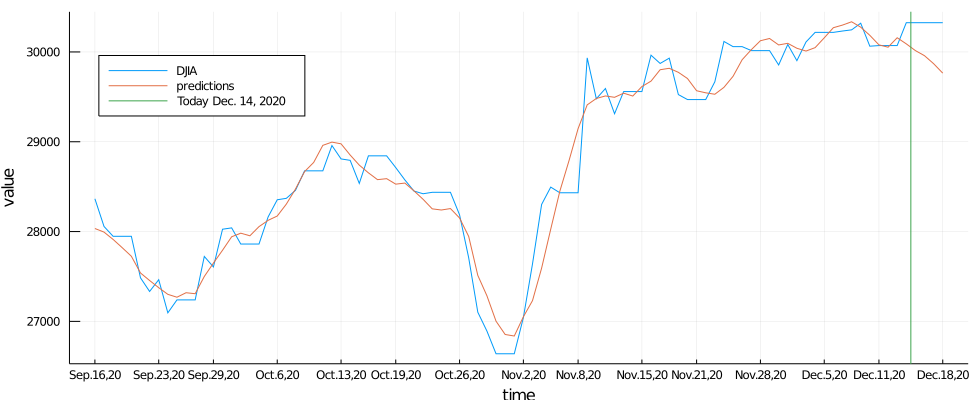

In [27]:
using Plots

#dates = format_dates( df[rows,2] , "m/d/yy")

gr()
plot(    x_axis_dates,
        [  y_axis_original y_axis_predicted 
        ], # y-axis
    label    = 
        [ symbol_to_predict "predictions"  "" ],
    legend   =:topleft, 
              # :right, :left, :top, :bottom, :inside, :best, :legend, :topright, :topleft, :bottomleft, :bottomright
    xlabel   = "time",
    ylabel   = "value",
    size     = (980, 400), # width, height
    layout = (1, 1), # number of graphs: vertically, horizontally
    )
## Add veritical today line
plot!([today_id], seriestype="vline", label=[ "Today "*t "" ],)


In [14]:
## save plot graph

savefig("../images/predictions_" * symbol_to_predict * ".png")

In [15]:
## print prediction comparisons
println(symbol_to_predict, " ", today())

file_path = "../DATA/predictions.csv"
open( file_path, "a") do file_handle # append
    
    for id in finem-10:finem
        if id <= today_id + 1 # Days to the future
            row = get(data_predictions, id) # get a dictionary of data from the SFrame
            date_string = row["Date"] # e.g. "2020-10-20"

            a = y_axis_predicted[id]
            b = y_axis_original[id]
            d = round(b-a, digits=3)
            date = convert(String, Dates.format( Date(date_string), "e, yyyy-mm-dd" ) )
            if id <= today_id
                println( date, "\t predicted ", a , "\t, but actual value was \t", b , "\t difference is ",  d  ) # di
            else
                println( date, "\t predicted ", a  ) # 

                txt_to_save =  
                    convert(String, Dates.format( today(), "yyyy-mm-dd" ) ) *","* 
                    convert(String, symbol_to_predict) *","* 
                    date_string *","* 
                    string(a) * "\n"
                
                write(file_handle, txt_to_save )
                
            end # if
        end #if 
    end # for
end # open file

DJIA 2020-12-14
Tue, 2020-12-08	 predicted 30336.0	, but actual value was 	30246.0	 difference is -90.0
Wed, 2020-12-09	 predicted 30276.0	, but actual value was 	30320.0	 difference is 44.0
Thu, 2020-12-10	 predicted 30185.0	, but actual value was 	30064.0	 difference is -121.0
Fri, 2020-12-11	 predicted 30079.0	, but actual value was 	30071.0	 difference is -8.0
Sat, 2020-12-12	 predicted 30053.0	, but actual value was 	30071.0	 difference is 18.0
Sun, 2020-12-13	 predicted 30158.0	, but actual value was 	30071.0	 difference is -87.0
Mon, 2020-12-14	 predicted 30090.0	, but actual value was 	30326.0	 difference is 236.0
Tue, 2020-12-15	 predicted 30015.0
